In [3]:
#decision tree
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  #graph and plot
import kmeans1 as km   #kmeans module
from sklearn.model_selection import KFold #for K fold cross validation

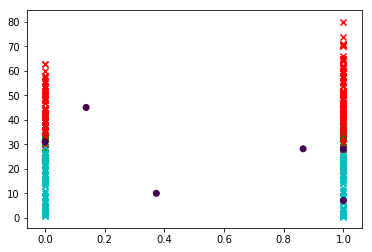

In [6]:
cl1, cl2, cl3=km.working("titanic dataset.csv")   
data, header= km.dataset("titanic dataset.csv")

#In the first block, we make 3 clusters using k means and store them. Also we
#store our full data and header in separate variables which we will use to compare our results.

In [7]:
def kfold(dataset):
    k_fold = KFold(n_splits=10)
    train_samples = []
    test_samples = []
    for train_indices, test_indices in k_fold.split(dataset):
        train_samples.append(dataset[train_indices[:]])
        test_samples.append(dataset[test_indices[:]])
        
    return [train_samples, test_samples]   
#returns list of 10 train samples and test samples using k fold cross validation
kfold(data)

[[array([[1, 59.0, 0, 0],
         [1, 71.0, 1, 0],
         [1, 23.0, 1, 1],
         ..., 
         [0, 19.0, 0, 1],
         [1, 26.0, 1, 1],
         [1, 32.0, 2, 0]], dtype=object), array([[1, 22.0, 0, 0],
         [0, 38.0, 1, 1],
         [0, 26.0, 0, 1],
         ..., 
         [0, 19.0, 0, 1],
         [1, 26.0, 1, 1],
         [1, 32.0, 2, 0]], dtype=object), array([[1, 22.0, 0, 0],
         [0, 38.0, 1, 1],
         [0, 26.0, 0, 1],
         ..., 
         [0, 19.0, 0, 1],
         [1, 26.0, 1, 1],
         [1, 32.0, 2, 0]], dtype=object), array([[1, 22.0, 0, 0],
         [0, 38.0, 1, 1],
         [0, 26.0, 0, 1],
         ..., 
         [0, 19.0, 0, 1],
         [1, 26.0, 1, 1],
         [1, 32.0, 2, 0]], dtype=object), array([[1, 22.0, 0, 0],
         [0, 38.0, 1, 1],
         [0, 26.0, 0, 1],
         ..., 
         [0, 19.0, 0, 1],
         [1, 26.0, 1, 1],
         [1, 32.0, 2, 0]], dtype=object), array([[1, 22.0, 0, 0],
         [0, 38.0, 1, 1],
         [0, 26.0, 0, 1

In [8]:
def class_counts(rows):
    counts = {}  # a dictionary of (y-variable)/label -> count/how many times it exits in data.
    for row in rows: 
        label = row[-1]
        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    return counts
# a dictionary of (y-variable)/label -> count/how many times it exits in data.

In [9]:
def is_numeric(value): 
    return isinstance(value, int) or isinstance(value, float)
#useful function that aids in creating questions

In [10]:
class Question:
    #Init and repr default functions. Init serve the purpose of defining object 
    #while repr is printable representation of the question.
    #Match function(example) compares the feature value in an (example) 
    #to the feature value in the node question. The comparision for numeric and non 
    #numeric variables is different. It returns true and false on which partitioning 
    #takes place on every node in partition function

    def __init__(self, column, value):
        self.column = column
        self.value = value

    def match(self, example):
        # Compare the feature value in an example to the
        # feature value in this question.
        val = example[self.column]
        if is_numeric(val):
            return val >= self.value
        else:
            return val == self.value
        
    def __repr__(self):
        # This is just a helper method to print
        # the question in a readable format.
        condition = "=="
        if is_numeric(self.value):
            condition = ">="
        return "Is %s %s %s?" % (header[self.column], condition, str(self.value))

In [11]:
def partition(data_rows, question):
    
    #Takes rows and returns true and false rows for any question given based on match function results
    
    true_rows, false_rows = [], []
    for row in data_rows:
        if question.match(row):
            true_rows.append(row)
        else:
            false_rows.append(row)
    return true_rows, false_rows

In [12]:
def gini(rows):
    counts = class_counts(rows) #class counts is a dict {label: counts}
    impurity = 1
    for lbl in counts:
        prob_of_lbl = counts[lbl] / float(len(rows))
        impurity -= prob_of_lbl**2
    return impurity

In [13]:
def info_gain(left, right, current_uncertainty):

    #The uncertainty of the starting node, minus the weighted impurity of
    #two child nodes.
    
    p = float(len(left)) / (len(left) + len(right))
    return current_uncertainty - p * gini(left) - (1 - p) * gini(right)

In [14]:
def find_best_split(rows):
    #Find the best question to ask by iterating over every feature / value
    #and calculating the information gain
    best_gain = 0  # keep track of the best information gain
    best_question = None  # keep track of the feature / value that produced it
    current_uncertainty = gini(rows)
    n_features = len(rows[0]) - 1  # number of columns

    for col in range(n_features):  # for each feature

        values = set([row[col] for row in rows])  # unique values in the column

        for val in values:  # for each value

            question = Question(col, val)

            # try splitting the dataset
            true_rows, false_rows = partition(rows, question)

            # Skip this split if it doesn't divide the
            # dataset.
            if len(true_rows) == 0 or len(false_rows) == 0:
                continue

            # Calculate the information gain from this split
            gain = info_gain(true_rows, false_rows, current_uncertainty)

            if gain >= best_gain:
                best_gain, best_question = gain, question

    return best_gain, best_question

In [15]:
class Leaf:
    # Leaf node classifies data.

    #This holds a dictionary of label -> number of times
    #it appears in the rows from the training data that reach this leaf.


    def __init__(self, rows):
        self.predictions = class_counts(rows)

In [16]:
class Decision_Node:
    
    #This holds a reference to the question, and to the two child nodes.
    def __init__(self,
                 question,
                 true_branch,
                 false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch

In [17]:
def build_tree(rows):


    # Try partitioing the dataset on each of the unique feature value,
    # calculate the information gain,
    # and return the question that produces the highest gain.
    gain, question = find_best_split(rows)

    # Base case: no further info gain
    # Since we can ask no further questions,
    # we'll return a leaf.
    if gain == 0:
        return Leaf(rows)

    # If we reach here, we have found a useful feature / value
    # to partition on.
    true_rows, false_rows = partition(rows, question)

    # Recursively build the true branch.
    true_branch = build_tree(true_rows)

    # Recursively build the false branch.
    false_branch = build_tree(false_rows)

    # Return a Question node.
    # This records the best feature / value to ask at this point,
    # as well as the branches to follow
    # dependingo on the answer.
    return Decision_Node(question, true_branch, false_branch)

In [18]:
def print_tree(node, spacing=""):
    """World's most elegant tree printing function."""

    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        print (spacing + "Predict", node.predictions)
        return

    # Print the question at this node
    print (spacing + str(node.question))

    # Call this function recursively on the true branch
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Call this function recursively on the false branch
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [19]:
def classify(row, node):

    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        return node.predictions

    if node.question.match(row):
        return classify(row, node.true_branch)
    else:
        return classify(row, node.false_branch)

In [20]:
def print_leaf(counts):
    total = sum(counts.values()) * 1.0
    probs = {}
    correct = 0
    for lbl in counts.keys():
        probs[lbl] = str(int(counts[lbl] / total * 100)) + "%"
        if (probs[lbl] == "100%"):
            correct = correct + 1
    return probs

In [21]:
def program(dataset):
    train_samples, test_samples = kfold(dataset)
    my_tree = []
    total_accuracy = 0
    
    for i in range (len(train_samples)):
        
        my_tree = build_tree(train_samples[i])
        #print_tree(my_tree)
        correct = 0
        
        for row in test_samples[i]:

            print ("Actual: %s. Predicted: %s" % (row[-1], print_leaf(classify(row, my_tree))))
    
            dict1 = print_leaf(classify(row, my_tree))
            more_probable_answer = max(dict1, key=dict1.get)
            
            if ((row[-1]) == more_probable_answer):
                correct = correct + 1 
            accuracy = str((correct/len(test_samples[i]))*100) + "%"
        total_accuracy = total_accuracy + ((correct/len(test_samples[i]))*100)
        print("\n The accuracy of this test set is ", accuracy)        
        print("\n \n")
    total_accuracy = (total_accuracy)/(len(train_samples))
    
    return total_accuracy

In [22]:
#program()
accuracy_kmeans = (program(cl1)*len(cl1)+ program(cl2)*len(cl2) + program(cl3)*len(cl3))/(len(cl1)+len(cl2)+len(cl3))
accuracy_dt = program(data)
print("Combined accuracy by clusters of k mean and DT:", accuracy_kmeans)
print("Accuracy by only DT:", accuracy_dt)

Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 1.0. Predicted: {0.0: '50%', 1.0: '50%'}
Actual: 1.0. Predicted: {1.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 0.0. Predicted: {1.0: '80%', 0.0: '20%'}
Actual: 0.0. Predicted: {0.0: '66%', 1.0: '33%'}
Actual: 1.0. Predicted: {0.0: '90%', 1.0: '10%'}
Actual: 1.0. Predicted: {0.0: '92%', 1.0: '7%'}
Actual: 1.0. Predicted: {0.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 0.0. Predicted: {0.0: '50%', 1.0: '50%'}
Actual: 0.0. Predicted: {1.0: '100%'}
Actual: 1.0. Predicted: {0.0: '66%', 1.0: '33%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 0.0. Predicted: {0.0: '50%', 1.0: '50%'}
Actual: 1.0. Predicted: {0.0: '66%', 1.0: '33%'}
Actual: 0.0. Predicted: {0.0: '80%', 1.0: '20%'}
Actual: 1.0. Predicted: {1.0: '100%'}
Actual: 0.0. Predicted: {0.0: '85%', 1.0: '14%'}
Actual: 0.0. Predicted: {0.0: '60%', 1.0: '40%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 0.0. Predicted: {1.0: '10

Actual: 0.0. Predicted: {0.0: '50%', 1.0: '50%'}
Actual: 1.0. Predicted: {1.0: '100%'}
Actual: 1.0. Predicted: {1.0: '100%'}
Actual: 0.0. Predicted: {1.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 1.0. Predicted: {1.0: '100%'}
Actual: 0.0. Predicted: {1.0: '100%'}
Actual: 0.0. Predicted: {0.0: '90%', 1.0: '10%'}
Actual: 0.0. Predicted: {0.0: '85%', 1.0: '14%'}
Actual: 0.0. Predicted: {1.0: '100%'}
Actual: 1.0. Predicted: {1.0: '100%'}
Actual: 0.0. Predicted: {1.0: '50%', 0.0: '50%'}
Actual: 1.0. Predicted: {0.0: '100%'}
Actual: 1.0. Predicted: {1.0: '100%'}
Actual: 0.0. Predicted: {1.0: '100%'}
Actual: 0.0. Predicted: {1.0: '100%'}
Actual: 0.0. Predicted: {0.0: '85%', 1.0: '14%'}
Actual: 1.0. Predicted: {0.0: '66%', 1.0: '33%'}
Actual: 1.0. Predicted: {1.0: '100%'}
Actual: 0.0. Predicted: {1.0: '100%'}
Actual: 0.0. Predicted: {1.0: '66%', 0.0: '33%'}

 The accuracy of this test set is  52.38095238095239%

 

Actual: 0.0. Predicted: {1.0: '100%'}
Actual: 1.0. Predicted: {1.0

In [28]:
#X = data[:,:-1]
#X = np.array(X,dtype=float)
#X

In [56]:
#y = data[:,-1].reshape(data.shape[0],1)
#y = np.array(y,dtype=float)

In [57]:
#from NNDeep import DeepNN

In [27]:
#print(X.shape)
#print(y.shape)

In [72]:
#NN = DeepNN([5,100,200,100,1])

In [26]:
#NN.learn(200000, 0.01,X,y,['reLU','sigmoid','sigmoid','sigmoid'],'log_loss',20000,'sgd',10)

In [25]:
#np.array(X,dtype=float)

In [110]:
#data = (pd.read_csv('titanic test.csv', delimiter=",", na_values=[" "], usecols = (1, 3, 4, 5, 10)))
#feature scaling of categorizical data to numeric for k means
#data.loc[(data.Sex.isin(['male'])), 'Sex'] = int(1)
#data.loc[(data.Sex.isin(['female'])), 'Sex'] = int(0)

#data.loc[(data.Embarked.isin(['S'])), 'Embarked'] = 0
#data.loc[(data.Embarked.isin(['C'])), 'Embarked'] = 1
#data.loc[(data.Embarked.isin(['Q'])), 'Embarked'] = 2


#data = np.array(data.fillna(0))

In [29]:
#X_test = np.array(data)
#X_test.shape

In [112]:
#y_test = np.round(NN.think(X_test)).reshape(1,418)

In [113]:
#y_test_ans = y_test.tolist()[0]

In [115]:
#import csv
#csvfile = "test file2.csv"

#Assuming res is a flat list
#with open(csvfile, "w") as output:
#    writer = csv.writer(output, lineterminator='\n')
#    for val in y_test_ans:
#        writer.writerow([val])